This notebook tries to explain why there is a plateau with respect to the number of basis states. 

In [1]:
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.ticker as tk
import re
import pickle
from scipy.stats import norm
from collections import OrderedDict
from glob import glob
from pyemma.coordinates.clustering import KmeansClustering
from pyemma.msm import MaximumLikelihoodMSM
import time

In [2]:
def score_trial(suggest, data_dir, ix=0, n_splits = 20, lag = 9, k = 5, method = 'VAMP2', stride = 10, 
                n_trajs = 750, test_size = 0.5, max_iter = 1000):
#     GLOBAL HYPERPARAMETERS
#     n_splits = 20 # CV splits
#     lag = 9 # msm lag time
#     k = 5 # num eigenvalues in score
#     method = 'VAMP2' # score method
#     stride = 10 # stride for clustering
#     n_trajs = 750 # number of trajectories - for checking whether we've loaded all the data. 
#     test_size = 0.5 # train/test split
#     max_iter = 1000 # for clustering algo
    
    # SUGGESTED HYPERPARAMETERS 
    # the 'suggest' dataframe 
    n = int(suggest.loc[suggest.index[ix], 'n'])
    feat = suggest.loc[suggest.index[ix], 'basis']
    feat_dir = data_dir + feat

    # load data
    traj_paths = glob(feat_dir+'/*.npy')
    assert len(traj_paths) == n_trajs
    trajs = [np.load(x) for x in traj_paths]

    # cross-validation loop
    cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size)
    test_scores = []
    train_scores = []
    
    for train_idx, test_idx in cv.split(trajs):
        train = [trajs[i] for i in train_idx]
        test = [trajs[i] for i in test_idx]

        # pipeline
        cluster = KmeansClustering(n_clusters=n, max_iter=max_iter, stride=stride)
        mod = MaximumLikelihoodMSM(lag=lag, score_k=k, score_method=method)

        # train
        z = cluster.fit_transform(train)
        z = [x.flatten() for x in z]
        mod.fit(z)
        score = mod.score(z)
        train_scores.append(score)
        
        # test
        z = cluster.transform(test)
        z = [x.flatten() for x in z]
        score = mod.score(z)
        test_scores.append(score)
        
    return {'n': n, 'basis': feat, 'test_scores': test_scores, 'train_scores': train_scores}




In [3]:
# These labels should self consistent! 
relabel = {'project_name': 'basis', 
           'cluster__n_clusters': 'n'}

search_space = OrderedDict([
    ('basis', np.array(['psi', 'phi', 'rmsd', 'positions', 'phipsi'])), 
    ('n', np.arange(10, 1001, 10, dtype='float64'))])
predictors = list(search_space.keys())
target = 'test_mean'

# For the response surface. 
formula = '0 + np.log(n) + C(basis)'
kernel = 'm52'

n_basis = search_space['basis'].shape[0]

# Start calculating the surface with this many observations
start_n = 40 # start_n/n_basis  = average per feature

# start optimization with this many observations
start_bayes_n = 50 # start_bayes_n/n_basis  = average per feature

# number of Bayesian optimisation trials
num_trials = 10

# number of independent iterations
n_iters = 10

# number of CV splits
n_splits = 20

# Directory locations
# This directory
root_dir = '/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_msms/Ala1/'
# This is where the 'random' trials come from. 
input_dir = root_dir+'outputs/'
# this is where all the output goes
output_dir = root_dir+'outputs/bayes_opt_gp_m52/'
# this is where the features are
data_dir = root_dir+'data/features/'

In [4]:
feat_dir = data_dir + 'phipsi'

traj_paths = glob(feat_dir+'/*.npy')
trajs = [np.load(x) for x in traj_paths]

In [24]:
zs = []
for n in [100, 500, 1000, 10000]:
    stride = 10
    max_iter = 1000
    cluster = KmeansClustering(n_clusters=n, max_iter=max_iter, stride=stride)
    zs.append(cluster.fit_transform(trajs))

100%|██████████| 100/100 [00:00<00:00, 124.68it/s]                           

100%|██████████| 500/500 [00:04<00:00, 104.82it/s]                             

100%|██████████| 1000/1000 [00:07<00:00, 140.84it/s]                            

100%|██████████| 10000/10000 [00:39<00:00, 250.08it/s]                            

100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


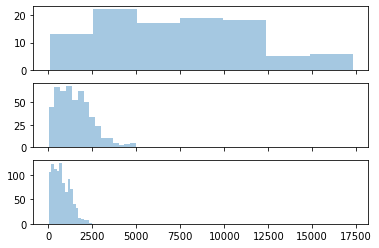

In [23]:
fig, axes = plt.subplots(3, sharex=True)
for i in range(3):
    u, c = np.unique(np.concatenate(zs[i]), return_counts=True)
    ix = np.argsort(c)
    c[ix]
    sns.distplot(c, ax=axes[i],kde=False)

<BarContainer object of 500 artists>

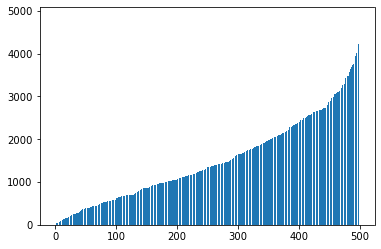

In [92]:
# SUGGESTED HYPERPARAMETERS 
# the 'suggest' dataframe 
# suggest, data_dir, ix=0, n_splits = 20, lag = 9, k = 5, method = 'VAMP2', stride = 10, 
#                 n_trajs = 750, test_size = 0.5, max_iter = 1000

test_scores = {'k': [], 'n': [], 'score': []}

for n in [100, 1000, 2000, 3000]:
#     n = 1000
    lag = 9
    k = 5
    method = 'VAMP2'
    n_trajs = 750
    stride = 10
    max_iter = 1000

    feat_dir = data_dir + 'phipsi'

    # load data
    traj_paths = glob(feat_dir+'/*.npy')
    assert len(traj_paths) == n_trajs
    trajs = [np.load(x) for x in traj_paths]

#     # 
#     train_scores = []
#     test_scores = []


    train = [x for x in trajs[:375]]
    test = [x for x in trajs[375:]]

    # pipeline
    cluster = KmeansClustering(n_clusters=n, max_iter=max_iter, stride=stride)
    mod = MaximumLikelihoodMSM(lag=lag, score_k=k, score_method=method, sparse=True)

    # train
    z_train = cluster.fit_transform(train)
    z_train = [x.flatten() for x in z_train]
    mod.fit(z_train)

    # test
    z_test = cluster.transform(test)
    z_test = [x.flatten() for x in z_test]

    for k in [5, 10, 20, 100]:
        test_scores['k'].append(k)
        test_scores['n'].append(n)
        test_scores['score'].append(mod.score(z_test, score_k =k))

KeyboardInterrupt: 

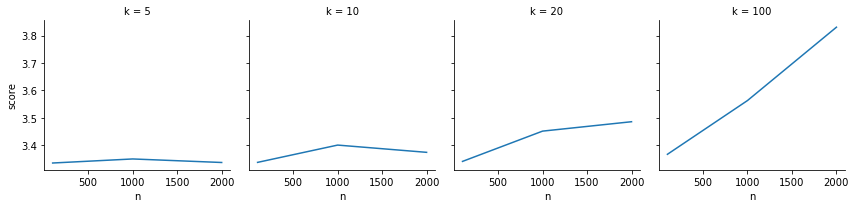

In [91]:
g = sns.FacetGrid(pd.DataFrame(test_scores), col='k')
g.map(plt.plot, 'n', 'score')